# 01 – Data Fetching Demo

This notebook demonstrates how to use our `data/fetch_data.py` utility to load market prices
and visualize them. We will:

1. Fetch data for a small set of tickers
2. Inspect the raw inputs
3. Plot the price series


In [1]:
# Imports
import os, sys, numpy as np, matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


from data.fetch_data import load_prices


### Step 1: Choose tickers and time window


In [2]:
### Step 1: Choose tickers and time window
tickers = ["META", "AAPL", "MSFT", "GOOGL", "AMZN"]
start_date = "2024-01-01"
end_date = "2024-12-31"


### Step 2: Fetch prices
We use the `load_prices` function from our package.  
This returns a **wide DataFrame**: rows = dates, columns = tickers.


In [3]:
prices = load_prices(tickers, start=start_date, end=end_date)
print("Shape:", prices.shape)
print("Columns:", prices.columns.tolist())
print(prices.head())


Shape: (251, 5)
Columns: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT']
Ticker            AAPL        AMZN       GOOGL        META        MSFT
Date                                                                  
2024-01-02  184.081512  149.929993  137.346283  344.400635  366.105530
2024-01-03  182.703171  148.470001  138.091827  342.590576  365.839050
2024-01-04  180.382843  144.570007  135.576920  345.226074  363.213196
2024-01-05  179.658951  145.240005  134.920822  350.029724  363.025635
2024-01-08  184.002182  149.100006  138.012299  356.703094  369.876465


### Step 3: Plot price series


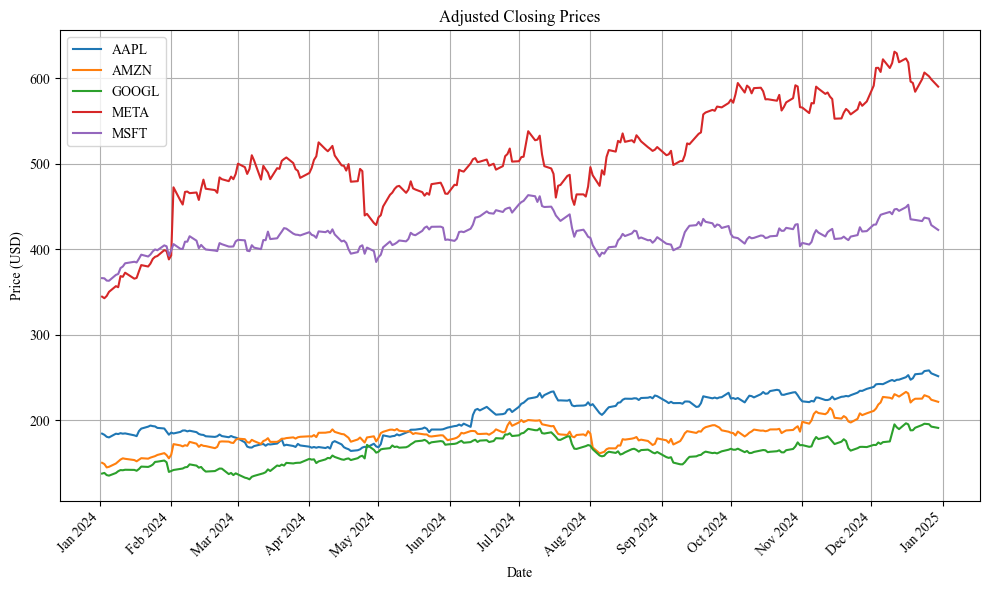

In [4]:

plt.figure(figsize=(10, 6))
ax = plt.gca()

prices.plot(ax=ax)

# Format x-axis by month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g. "Jan 2022"

plt.title("Adjusted Closing Prices")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.grid(True)
plt.legend(loc="upper left")

plt.xticks(rotation=45)  # rotate labels for readability
plt.tight_layout()
plt.show()


### Step 4: Plot normalized (rebased) prices
Often we normalize all tickers to start at 1.0 to compare growth.


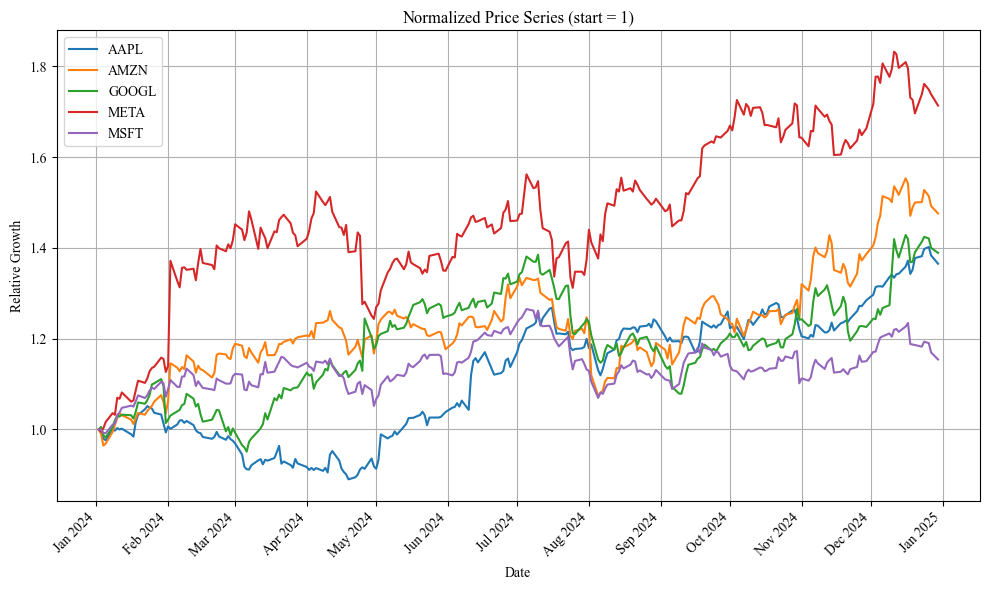

In [5]:
normalized = prices / prices.iloc[0]
plt.figure(figsize=(10, 6))
ax = plt.gca()

normalized.plot(ax=ax)

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   # tick every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))   # e.g. "Jan 2022"

plt.title("Normalized Price Series (start = 1)")
plt.ylabel("Relative Growth")
plt.xlabel("Date")
plt.grid(True)
plt.legend(loc="upper left")

plt.xticks(rotation=45)  # rotate labels
plt.tight_layout()
plt.show()

## How We Calculate Weights and Portfolio Value

### 1. Calculating Weights
- For each stock (ticker), we obtain the **free float**:  
  the number of shares available for trading (excluding insider holdings, restricted shares, etc.).
- We then compute the **total free float** across all stocks in the portfolio:
  $
  \text{Total Free Float} = \sum_i \text{Free Float}(i)
  $
- The **weight** of each stock is its share of the total free float:
  $
  w_i = \frac{\text{Free Float}(i)}{\text{Total Free Float}}
  $
- These weights ensure that stocks with larger free floats (i.e., more liquid, widely traded)  
  have a proportionally larger influence on the portfolio.

---

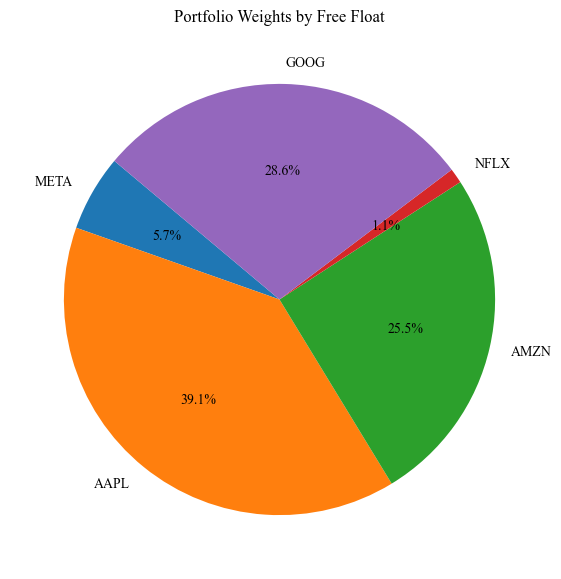

In [6]:
import matplotlib.pyplot as plt
from portfolio.free_float import build_portfolio_from_free_float
#FAANG
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]

# Build weights and portfolio
df_w, df_p = build_portfolio_from_free_float(
    tickers,
    start="2024-01-01",
    end="2025-01-01",
    initial_investment=1000.0
)


weights = df_w.set_index("Ticker")["Free Float Weight"].dropna()

plt.figure(figsize=(7,7))
plt.pie(weights, labels=weights.index, autopct="%1.1f%%", startangle=140)
plt.title("Portfolio Weights by Free Float")
plt.show()

### 2. Calculating Portfolio Value
- For each day $t$, we calculate the **percentage change** (daily return) of each stock:
  $
  r_{i,t} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}}
  $
  where $P_{i,t}$ is the closing price of stock $i$ at time $t$.

- The **portfolio return** on day $t$ is the weighted sum of individual returns:
  $
  R_t = \sum_i w_i \cdot r_{i,t}
  $

- Starting from an initial investment $V_0$ (e.g., \$1000),  
  the portfolio value updates each day via compounding:
  $
  V_t = V_{t-1} \times (1 + R_t)
  $

---

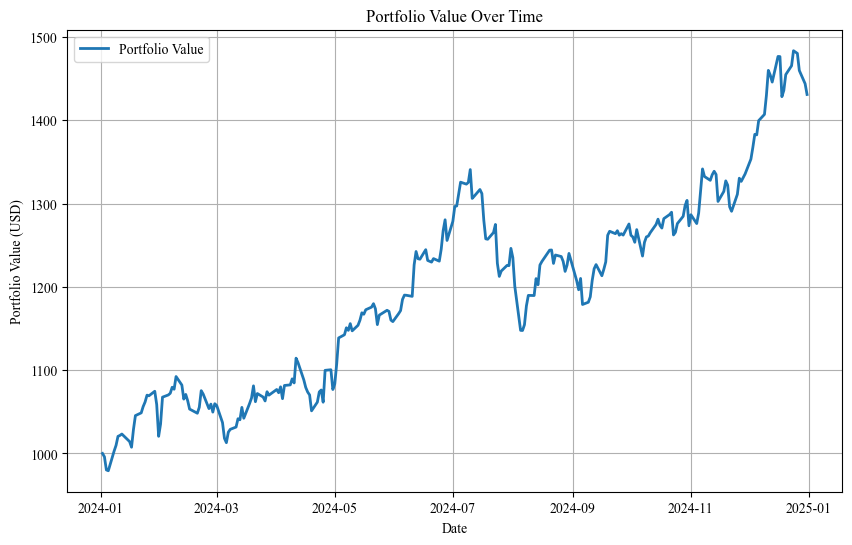

In [7]:
# Plot portfolio value vs time
plt.figure(figsize=(10, 6))
plt.plot(df_p.index, df_p["Portfolio Value"], label="Portfolio Value", linewidth=2)
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.grid(True)
plt.legend()
plt.show()


## Portfolio vs. Single Stock Comparison

In the chart, we overlay the **portfolio value** against **Apple’s (AAPL) price performance**, both normalized to start at the same initial value (e.g., $1000).  

### What we see
- **Portfolio smoothing effect**:  
  The portfolio curve is generally smoother than the AAPL line. This is because portfolio returns are an average across multiple stocks, reducing the impact of sharp swings in any one ticker.  

- **Outperformance vs. underperformance**:  
  - If AAPL strongly outperforms the group, its line will rise faster than the portfolio.  
  - If AAPL underperforms, the portfolio will look stronger in comparison, showing the **diversification benefit**.  

- **Tracking behavior**:  
  Since AAPL typically has a large free float, it may carry significant weight in the portfolio. Thus, movements in the portfolio will still correlate strongly with AAPL, but they are not identical.  

### Key takeaway
The overlay highlights the **trade-off between concentration and diversification**:  
- Holding only AAPL gives higher upside potential but also higher volatility.  
- Holding the free-float-weighted portfolio reduces exposure to a single stock’s risk, creating a more stable growth trajectory.


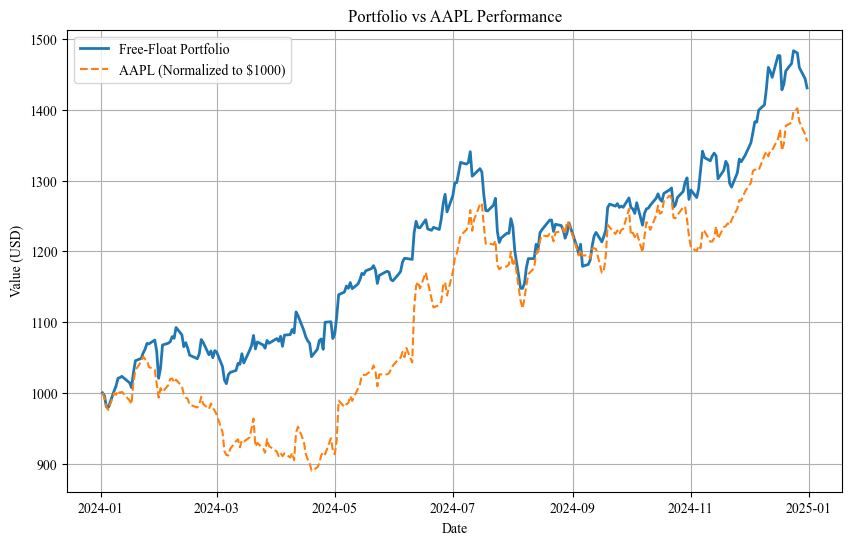

In [8]:

#Get AAPL prices (same date range)
aapl_prices = load_prices(["AAPL"], start="2024-01-01", end="2025-01-01", auto_adjust=True)

# Normalize AAPL price series to start at 1000 like the portfolio
aapl_normalized = aapl_prices["AAPL"] / aapl_prices["AAPL"].iloc[0] * 1000

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(df_p.index, df_p["Portfolio Value"], label="Free-Float Portfolio", linewidth=2)
plt.plot(aapl_normalized.index, aapl_normalized, label="AAPL (Normalized to $1000)", linestyle="--")
plt.title("Portfolio vs AAPL Performance")
plt.xlabel("Date")
plt.ylabel("Value (USD)")
plt.grid(True)
plt.legend()
plt.show()
